# 4.1. Time-Frequency Analysis

**Learning Objectives:**
- Understand the difference between time-domain and frequency-domain representations
- Learn why time-frequency analysis is essential for neuroimaging
- Compute and visualize spectrograms using different methods
- Apply wavelet transforms to EEG/MEG data
- Use multitaper methods for robust spectral estimation
- Interpret event-related spectral perturbations (ERSP)

**Key Concepts:**
- **Time-Frequency Trade-off**: The uncertainty principle in signal processing
- **Wavelets**: Localized oscillations for analyzing non-stationary signals
- **Spectrograms**: Visual representation of signal frequency content over time
- **Event-Related Spectral Perturbation (ERSP)**: Changes in power relative to baseline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper
from mne.datasets import sample
from pathlib import Path 
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

### 1. Understanding Time-Frequency Analysis

#### Why Do We Need Time-Frequency Analysis?

Brain signals are **non-stationary** – their frequency content changes over time. Traditional Fourier analysis only tells us *what* frequencies are present, but not *when* they occur.

**Example scenarios:**
- **Alpha rhythm (8-12 Hz)**: Increases when eyes are closed, decreases during visual tasks
- **Beta oscillations (13-30 Hz)**: Burst during motor preparation and execution
- **Gamma band (30-100 Hz)**: Brief increases during cognitive processing

Time-frequency methods let us track these dynamic changes.

#### The Time-Frequency Trade-off

The **Heisenberg uncertainty principle** applies to signal processing:
- **High temporal resolution** → Poor frequency resolution
- **High frequency resolution** → Poor temporal resolution

Different methods handle this trade-off differently.

### 2. Load Sample Data

We'll use the MNE sample dataset containing MEG/EEG recordings of auditory and visual stimuli.

In [3]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "meg_sample"
target_dir.mkdir(parents=True, exist_ok=True)

data_path = sample.data_path(path=str(target_dir), download=True)
meg_file = Path(data_path) / "MEG" / "sample" / "sample_audvis_raw.fif"
events_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_raw-eve.fif'

raw = mne.io.read_raw_fif(meg_file, preload=True)
events = mne.read_events(events_fname)

# Focus on EEG channels 
raw.pick_types(meg=False, eeg=True, eog=False, stim=False)

print(f"Channels: {raw.ch_names[:5]}... and {raw.ch_names[-1]}")


Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channels: ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005']... and EEG 060


### 3. Data Preprocessing

In [4]:
# Apply basic preprocessing
raw.filter(l_freq=1.0, h_freq=40.0, verbose=False)

<Raw | sample_audvis_raw.fif, 59 x 166800 (277.7 s), ~78.0 MiB, data loaded>

In [5]:
# Create event dictionary
event_id = {'auditory/left': 1, 'auditory/right': 2, 
            'visual/left': 3, 'visual/right': 4}

In [6]:
print(f"Loaded {len(raw.ch_names)} EEG channels")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.1f} seconds")
print(f"Found {len(events)} events")

Loaded 59 EEG channels
Sampling frequency: 600.614990234375 Hz
Duration: 277.7 seconds
Found 320 events


### 4. Create Epochs

We'll epoch the data around stimulus events to analyze event-related changes.

In [7]:
# Create epochs: -0.5 to 1.5 seconds around each event
epochs = mne.Epochs(raw, events, event_id, 
                    tmin=-0.5, tmax=1.5,
                    baseline=(-0.5, 0),
                    preload=True,
                    verbose=False)

In [8]:
# Select auditory epochs for analysis
epochs_auditory = epochs['auditory']

print(f"Created {len(epochs_auditory)} auditory epochs")
print(f"Epoch duration: {epochs_auditory.tmax - epochs_auditory.tmin:.2f} seconds")

Created 145 auditory epochs
Epoch duration: 2.00 seconds


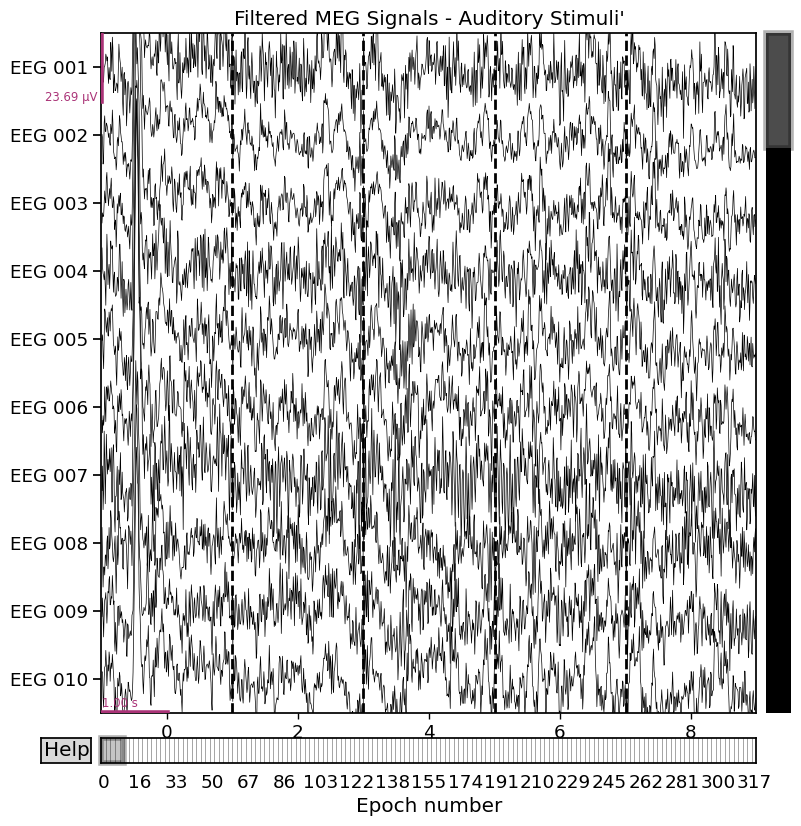

In [11]:
# Visualize a few epochs
fig = epochs_auditory.plot(n_epochs=5, n_channels=10, scalings='auto', show=False)

ax = fig.axes[0] 
ax.set_title("Filtered MEG Signals - Auditory Stimuli'")

plt.show()

### 5. Method 1: Short-Time Fourier Transform (STFT)

The **STFT** divides the signal into short time windows and applies Fourier transform to each window.

**Parameters:**
- **Window size**: Determines time-frequency resolution trade-off
- **Window overlap**: Controls smoothness of the spectrogram

**Pros:** Fast, simple, well-understood  
**Cons:** Fixed time-frequency resolution

In [16]:
# Select a single channel and epoch for demonstration
channel = 'EEG 021'  # An occipital electrode
epoch_idx = 0
data = epochs_auditory.get_data(picks=channel)[epoch_idx, 0, :]
times = epochs_auditory.times
sfreq = epochs_auditory.info['sfreq']

In [17]:
# Compute STFT spectrogram
frequencies, times_stft, Sxx = signal.spectrogram(
    data, 
    fs=sfreq,
    window='hann',
    nperseg=int(0.5 * sfreq),  # 500 ms window
    noverlap=int(0.45 * sfreq),  # 90% overlap
    scaling='density'
)

In [28]:
# Plot spectrogram
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

In [29]:
# Time-domain signal
axes[0].plot(times, data * 1e6, color='black', linewidth=0.8)
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label='Stimulus onset')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].set_title(f'Time-Domain Signal - Channel {channel}')
axes[0].legend()
axes[0].grid(alpha=0.3)

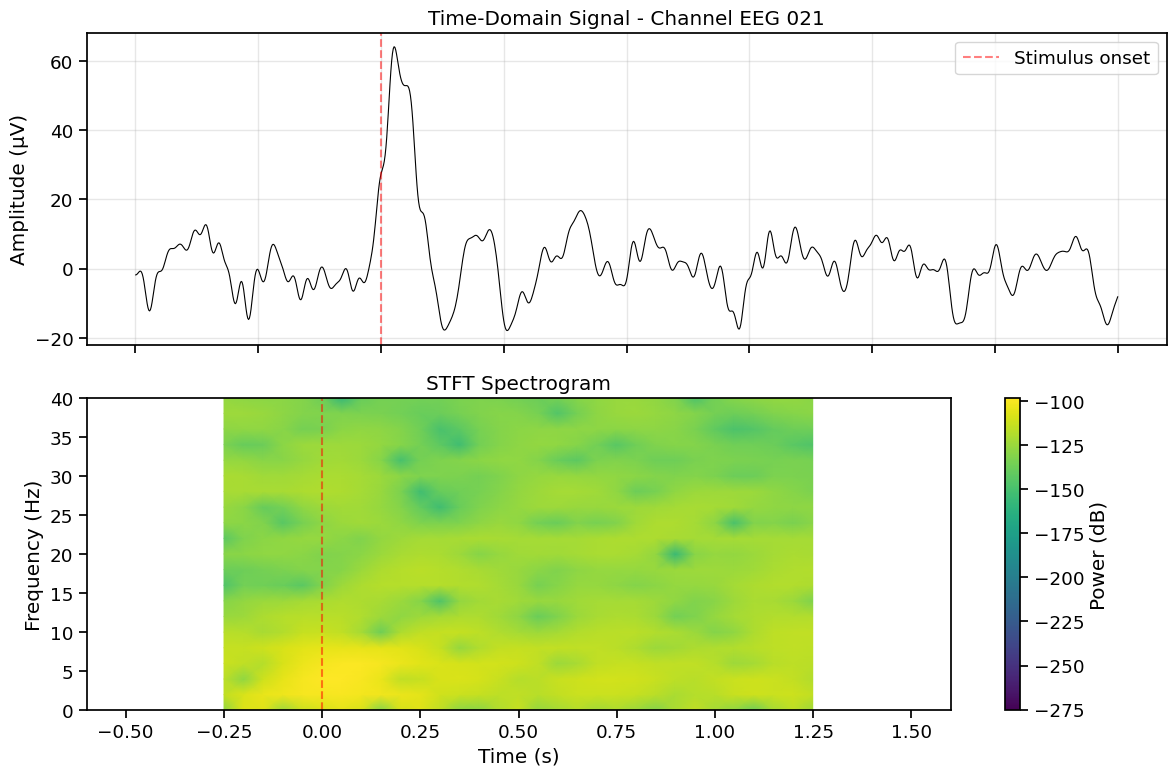

In [30]:
# Spectrogram
im = axes[1].pcolormesh(times_stft + epochs_auditory.tmin, frequencies, 
                         10 * np.log10(Sxx), 
                         shading='gouraud', cmap='viridis')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('STFT Spectrogram')
axes[1].set_ylim([0, 40])

plt.colorbar(im, ax=axes[1], label='Power (dB)')

plt.tight_layout()
plt.show()

### 6. Method 2: Morlet Wavelet Transform

**Wavelets** are "little waves" – oscillations that are localized in time. The **Morlet wavelet** is a complex sine wave windowed by a Gaussian envelope.

**Key advantages:**
- Adaptive time-frequency resolution
- Higher frequency resolution at low frequencies
- Higher temporal resolution at high frequencies

**Parameters:**
- **Number of cycles**: Controls the trade-off (more cycles = better frequency resolution)
- **Frequency range**: Which frequencies to analyze

In [32]:
# Define frequencies of interest (logarithmically spaced)
freqs = np.logspace(np.log10(4), np.log10(40), num=30)
print(f"Frequencies of interest: {freqs}")

Frequencies of interest: [ 4.          4.33054694  4.68840919  5.07584401  5.49529518  5.94940843
  6.44104811  6.97331529  7.54956729  8.17343887  8.84886516  9.58010648
 10.37177519 11.22886482 12.15678153 13.16137825 14.24899156 15.42648168
 16.70127575 18.08141463 19.57560367 21.19326763 22.94461004 24.84067768
 26.89343015 29.11581538 31.52185126 34.1267141  36.94683429 40.        ]


In [34]:
# More cycles = better frequency resolution, worse temporal resolution
n_cycles = freqs / 2.0  # Adaptive: higher frequencies get more cycles
print(f"Number of cycles for each frequency: {n_cycles}")

Number of cycles for each frequency: [ 2.          2.16527347  2.3442046   2.53792201  2.74764759  2.97470421
  3.22052406  3.48665764  3.77478364  4.08671944  4.42443258  4.79005324
  5.18588759  5.61443241  6.07839076  6.58068912  7.12449578  7.71324084
  8.35063787  9.04070731  9.78780184 10.59663381 11.47230502 12.42033884
 13.44671507 14.55790769 15.76092563 17.06335705 18.47341714 20.        ]


In [35]:
# Compute time-frequency representation using Morlet wavelets
power = tfr_morlet(epochs_auditory, freqs=freqs, n_cycles=n_cycles,
                   use_fft=True, return_itc=False, 
                   average=False, verbose=False)

print(f"TFR shape: {power.data.shape}")
print(f"(n_epochs, n_channels, n_freqs, n_times)")

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
TFR shape: (145, 59, 30, 1202)
(n_epochs, n_channels, n_freqs, n_times)


In [40]:
channel_idx = power.ch_names.index('EEG 021')
# Extract power for this channel and average across epochs
power_avg = np.mean(power.data[:, channel_idx, :, :], axis=0)
# Convert to dB
power_db = 10 * np.log10(power_avg)

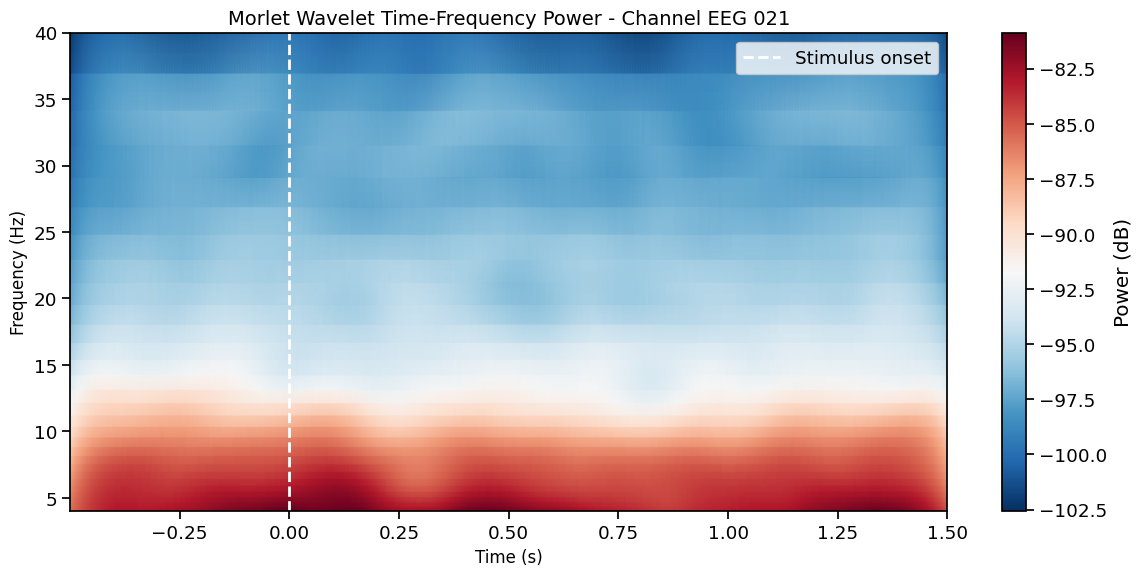

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.pcolormesh(power.times, freqs, power_db, 
                   shading='gouraud', cmap='RdBu_r')
ax.axvline(0, color='white', linestyle='--', linewidth=2, label='Stimulus onset')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=12)
ax.set_title(f'Morlet Wavelet Time-Frequency Power - Channel {channel}', fontsize=14)
ax.legend(loc='upper right')
cbar = plt.colorbar(im, ax=ax, label='Power (dB)')

plt.tight_layout()
plt.show()

### 7. Event-Related Spectral Perturbation (ERSP)

**ERSP** shows how power changes relative to a baseline period. This helps us see event-related increases or decreases in specific frequency bands.

**Formula:** ERSP = 10 × log₁₀(Power / Baseline Power)

Where:
- `Power(f, t)`: Power at frequency `f` and time `t`
- `Baseline_Power(f)`: Average power at frequency `f` during the baseline period
- The result shows relative change in decibels (dB)

**Interpretation:**
- **Positive values (warm colors)**: Event-related synchronization (ERS) - power increase
- **Negative values (cool colors)**: Event-related desynchronization (ERD) - power decrease
- Notice alpha-band suppression after stimulus onset (ERD)

In [42]:
# Compute baseline-corrected power
baseline_mask = (power.times >= -0.5) & (power.times < 0)
baseline_power = np.mean(power_avg[:, baseline_mask], axis=1, keepdims=True)

# ERSP in dB
ersp = 10 * np.log10(power_avg / baseline_power)

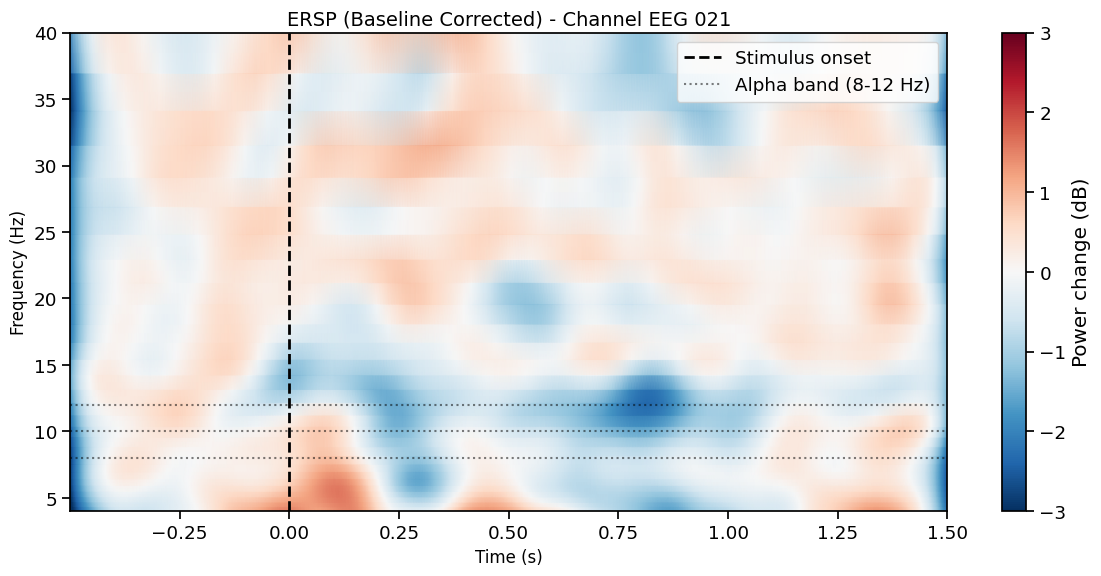

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.pcolormesh(power.times, freqs, ersp, shading='gouraud', cmap='RdBu_r', vmin=-3, vmax=3)  # Symmetric color scale
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Stimulus onset')
ax.axhline(10, color='black', linestyle=':', linewidth=1.5, alpha=0.5, label='Alpha band (8-12 Hz)')
ax.axhline(8, color='black', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axhline(12, color='black', linestyle=':', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=12)
ax.set_title(f'ERSP (Baseline Corrected) - Channel {channel}', fontsize=14)
ax.legend(loc='upper right')
cbar = plt.colorbar(im, ax=ax, label='Power change (dB)')

plt.tight_layout()
plt.show()

### 8. Method 3: Multitaper Method

The **multitaper method** uses multiple orthogonal tapers (windows) to estimate power, providing:
- **Reduced variance** in spectral estimates
- **Better statistical properties**
- **Good for group-level analysis**

**Trade-off:** Slightly lower frequency resolution than wavelets

In [46]:
# Compute time-frequency using multitaper method
freqs_mt = np.arange(4, 41, 2)  # 4 to 40 Hz in 2 Hz steps
n_cycles_mt = freqs_mt / 2.0

power_mt = tfr_multitaper(epochs_auditory, freqs=freqs_mt, 
                          n_cycles=n_cycles_mt,
                          use_fft=True, return_itc=False,
                          average=False, verbose=False)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


In [47]:
# Average and compute ERSP
power_mt_avg = np.mean(power_mt.data[:, channel_idx, :, :], axis=0)
baseline_mt = np.mean(power_mt_avg[:, baseline_mask], axis=1, keepdims=True)
ersp_mt = 10 * np.log10(power_mt_avg / baseline_mt)

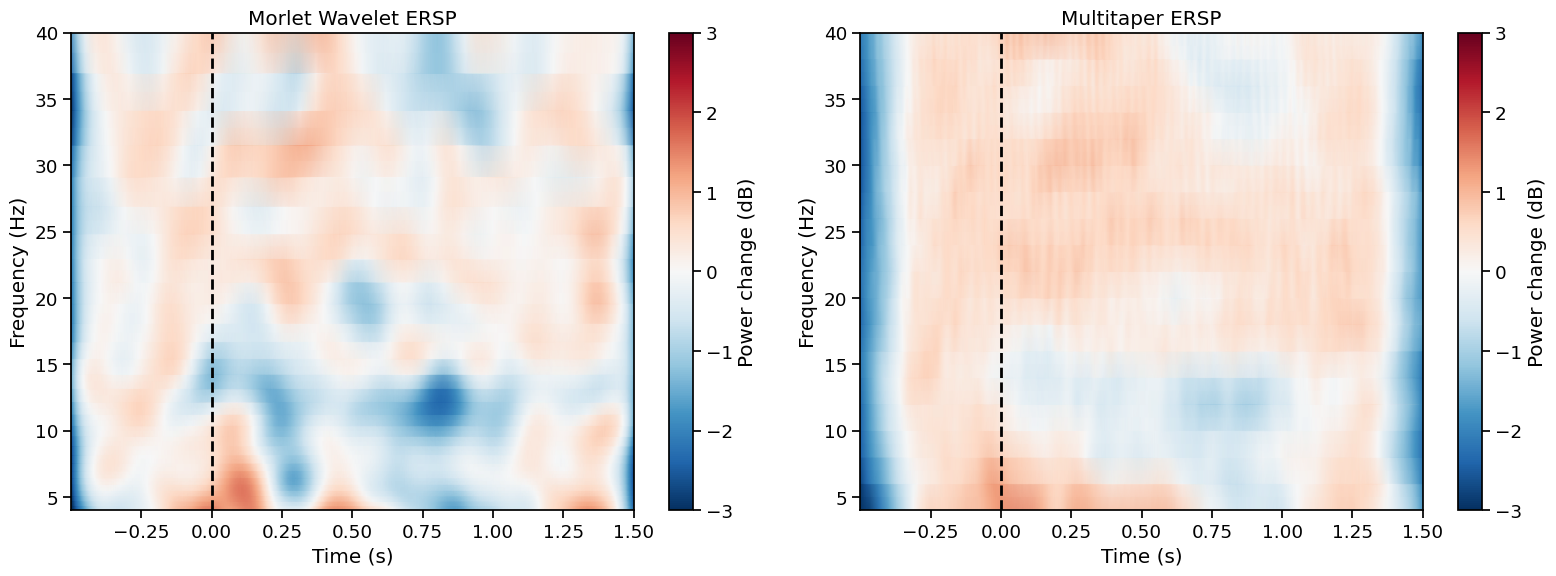

In [48]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Morlet wavelet
im1 = axes[0].pcolormesh(power.times, freqs, ersp, shading='gouraud', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0].axvline(0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_title('Morlet Wavelet ERSP')
plt.colorbar(im1, ax=axes[0], label='Power change (dB)')

# Multitaper
im2 = axes[1].pcolormesh(power_mt.times, freqs_mt, ersp_mt, shading='gouraud', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_title('Multitaper ERSP')
plt.colorbar(im2, ax=axes[1], label='Power change (dB)')

plt.tight_layout()
plt.show()

Multitaper method provides smoother, less noisy estimates

### 9. Analyzing Specific Frequency Bands

Brain oscillations are typically grouped into frequency bands with distinct functional roles:

| Band | Frequency Range | Associated Functions |
|------|----------------|---------------------|
| **Delta** | 1-4 Hz | Deep sleep, unconsciousness |
| **Theta** | 4-8 Hz | Memory, drowsiness, meditation |
| **Alpha** | 8-12 Hz | Relaxed wakefulness, eyes closed |
| **Beta** | 13-30 Hz | Active thinking, focus, anxiety |
| **Gamma** | 30-100 Hz | Cognitive processing, attention |

Let's extract and visualize power in specific bands over time.

In [53]:
bands = {
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-12 Hz)': (8, 12),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-40 Hz)': (30, 40)
}

In [64]:
fig, axes = plt.subplots(len(bands), 1, figsize=(12, 10), sharex=True)

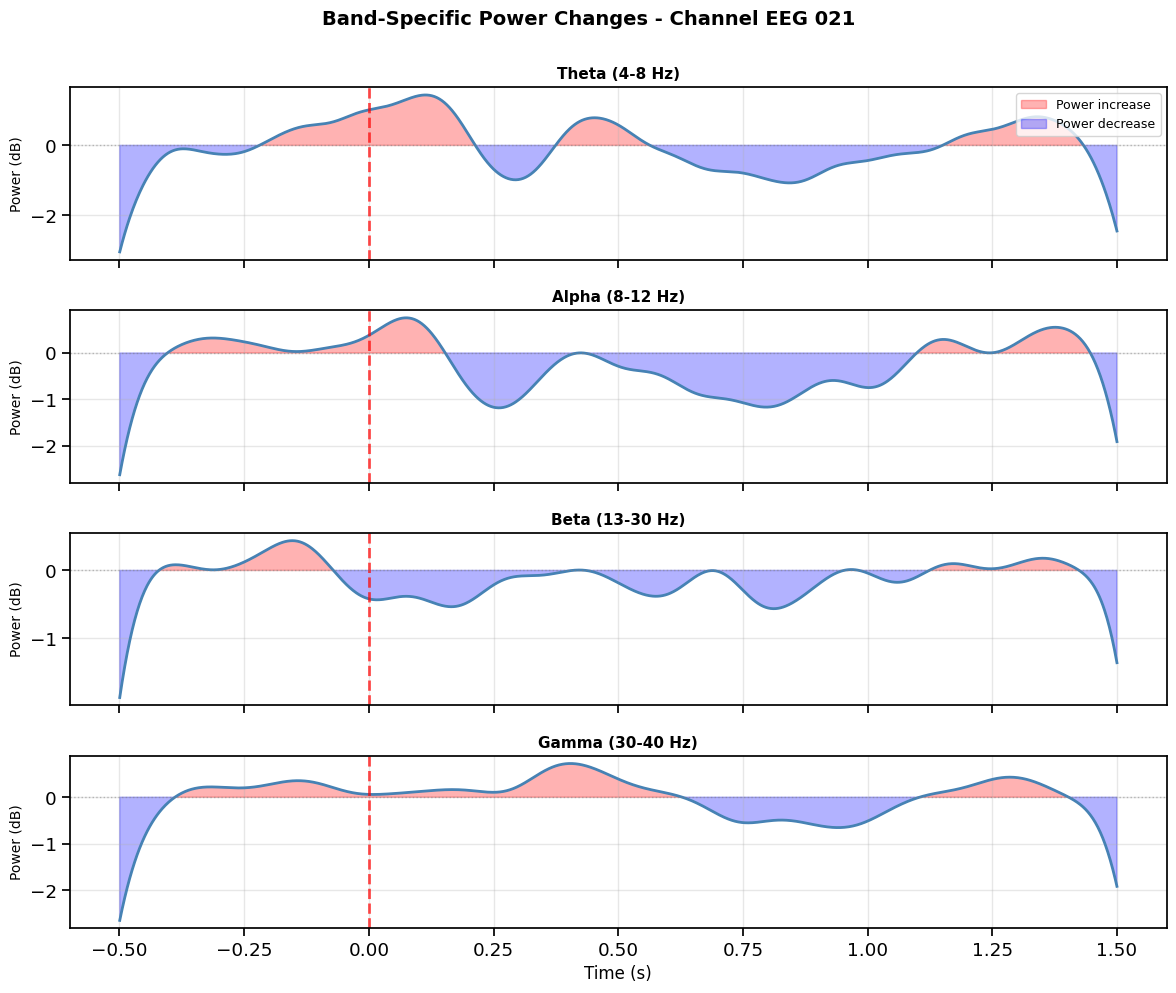

In [55]:
# Extract power for each band
for idx, (band_name, (fmin, fmax)) in enumerate(bands.items()):
    
    # Find frequency indices
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    
    # Average power across frequencies in this band
    band_power = np.mean(power_avg[freq_mask, :], axis=0)
    
    # Compute baseline
    baseline_band = np.mean(band_power[baseline_mask])
    
    # Convert to dB change
    band_ersp = 10 * np.log10(band_power / baseline_band)
    
    # Plot
    axes[idx].plot(power.times, band_ersp, linewidth=2, color='steelblue')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[idx].axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    axes[idx].fill_between(power.times, 0, band_ersp, where=(band_ersp > 0), alpha=0.3, color='red', label='Power increase')
    axes[idx].fill_between(power.times, 0, band_ersp, where=(band_ersp < 0), alpha=0.3, color='blue', label='Power decrease')
    axes[idx].set_ylabel('Power (dB)', fontsize=10)
    axes[idx].set_title(band_name, fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    if idx == 0:
        axes[idx].legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Time (s)', fontsize=12)

plt.suptitle(f'Band-Specific Power Changes - Channel {channel}', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 10. Topographic Distribution of Power

Let's visualize how power changes are distributed across the scalp for different frequency bands.

**Interpretation:**
- Each map shows spatial distribution of power changes
- Warm colors: power increase (ERS)
- Cool colors: power decrease (ERD)

In [56]:
# Compute average TFR across all channels
power_all = tfr_morlet(epochs_auditory, freqs=freqs, n_cycles=n_cycles,
                       use_fft=True, return_itc=False,
                       average=True, verbose=False)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [62]:
# Select time windows and frequency bands to visualize
time_windows = [0.1, 0.3, 0.6, 0.9, 0.12]  # Post-stimulus times
freq_bands = [(4,8, 'Thetha'), (8, 12, 'Alpha'), (13, 30, 'Beta'), (30,40, 'Gamma')]

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


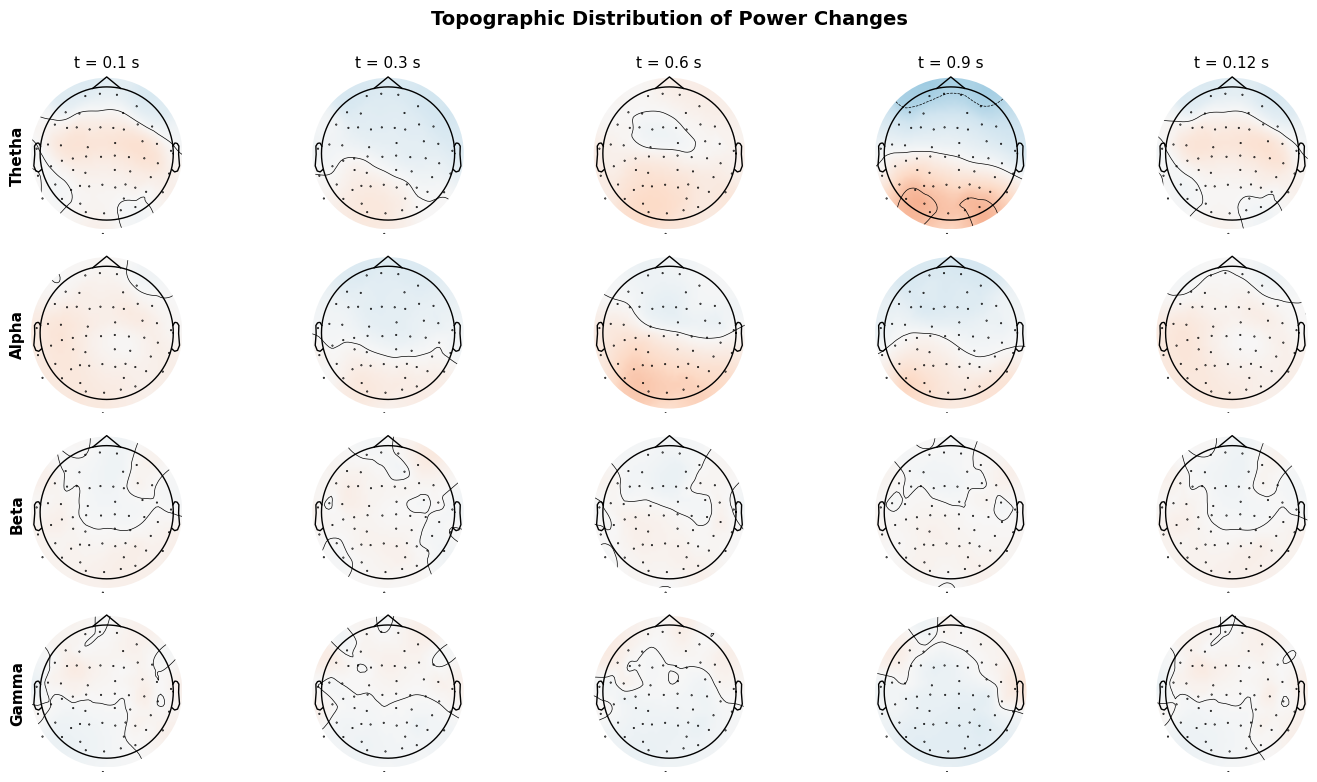

In [63]:
ig, axes = plt.subplots(len(freq_bands), len(time_windows), 
                         figsize=(15, 8))

for row, (fmin, fmax, band_name) in enumerate(freq_bands):
    for col, time_point in enumerate(time_windows):
        ax = axes[row, col]
        
        # Plot topomap for this band and time
        power_all.plot_topomap(
            tmin=time_point - 0.05, tmax=time_point + 0.05,
            fmin=fmin, fmax=fmax,
            baseline=(-0.5, 0), mode='logratio',
            axes=ax, show=False, colorbar=False,
            vlim=(-1, 1)
        )
        
        if row == 0:
            ax.set_title(f't = {time_point} s', fontsize=11)
        if col == 0:
            ax.set_ylabel(band_name, fontsize=11, fontweight='bold')

plt.suptitle('Topographic Distribution of Power Changes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 11. Inter-Trial Coherence (ITC)

**ITC** (also called phase-locking factor) measures the consistency of phase across trials at each time-frequency point.

**Key differences from power:**
- **Power**: Measures signal strength (can be high even if phase is random)
- **ITC**: Measures phase consistency (high when oscillations align across trials)

**Range:** 0 (random phase) to 1 (perfect phase alignment)

In [65]:
# Compute power and ITC
power_itc, itc = tfr_morlet(epochs_auditory, freqs=freqs, n_cycles=n_cycles,
                            use_fft=True, return_itc=True,
                            average=True, verbose=False)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [68]:
# Plot ITC for a specific channel
channel_idx = itc.ch_names.index('EEG 021')
itc_data = itc.data[channel_idx, :, :]

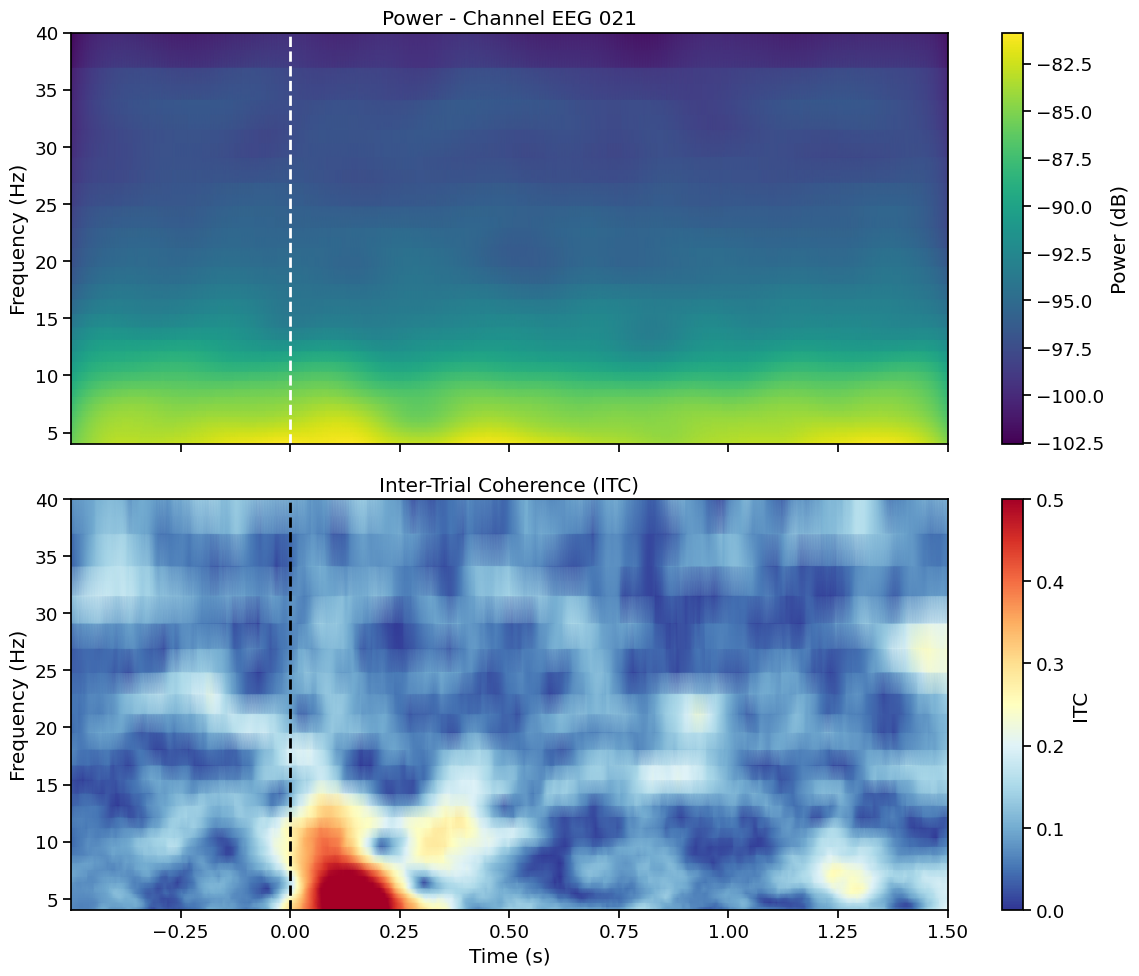

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Power
power_data = 10 * np.log10(power_itc.data[channel_idx, :, :])
im1 = axes[0].pcolormesh(power_itc.times, freqs, power_data, shading='gouraud', cmap='viridis')
axes[0].axvline(0, color='white', linestyle='--', linewidth=2)
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_title(f'Power - Channel {channel}')
plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# ITC
im2 = axes[1].pcolormesh(itc.times, freqs, itc_data,
                         shading='gouraud', cmap='RdYlBu_r',
                         vmin=0, vmax=0.5)
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_title('Inter-Trial Coherence (ITC)')
plt.colorbar(im2, ax=axes[1], label='ITC')

plt.tight_layout()
plt.show()

### 12. Comparing Auditory vs Visual Stimuli

Let's compare time-frequency responses to different stimulus types.

In [70]:
# Compute TFR for visual epochs
epochs_visual = epochs['visual']
power_visual = tfr_morlet(epochs_visual, freqs=freqs, n_cycles=n_cycles,
                          use_fft=True, return_itc=False,
                          average=True, verbose=False)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [71]:
# Extract data for comparison
channel = 'EEG 021'
channel_idx = power_all.ch_names.index(channel)

In [72]:
# Auditory (already computed)
power_aud_avg = power_all.data[channel_idx, :, :]
baseline_aud = np.mean(power_aud_avg[:, baseline_mask], axis=1, keepdims=True)
ersp_aud = 10 * np.log10(power_aud_avg / baseline_aud)

# Visual
power_vis_avg = power_visual.data[channel_idx, :, :]
baseline_vis = np.mean(power_vis_avg[:, baseline_mask], axis=1, keepdims=True)
ersp_vis = 10 * np.log10(power_vis_avg / baseline_vis)

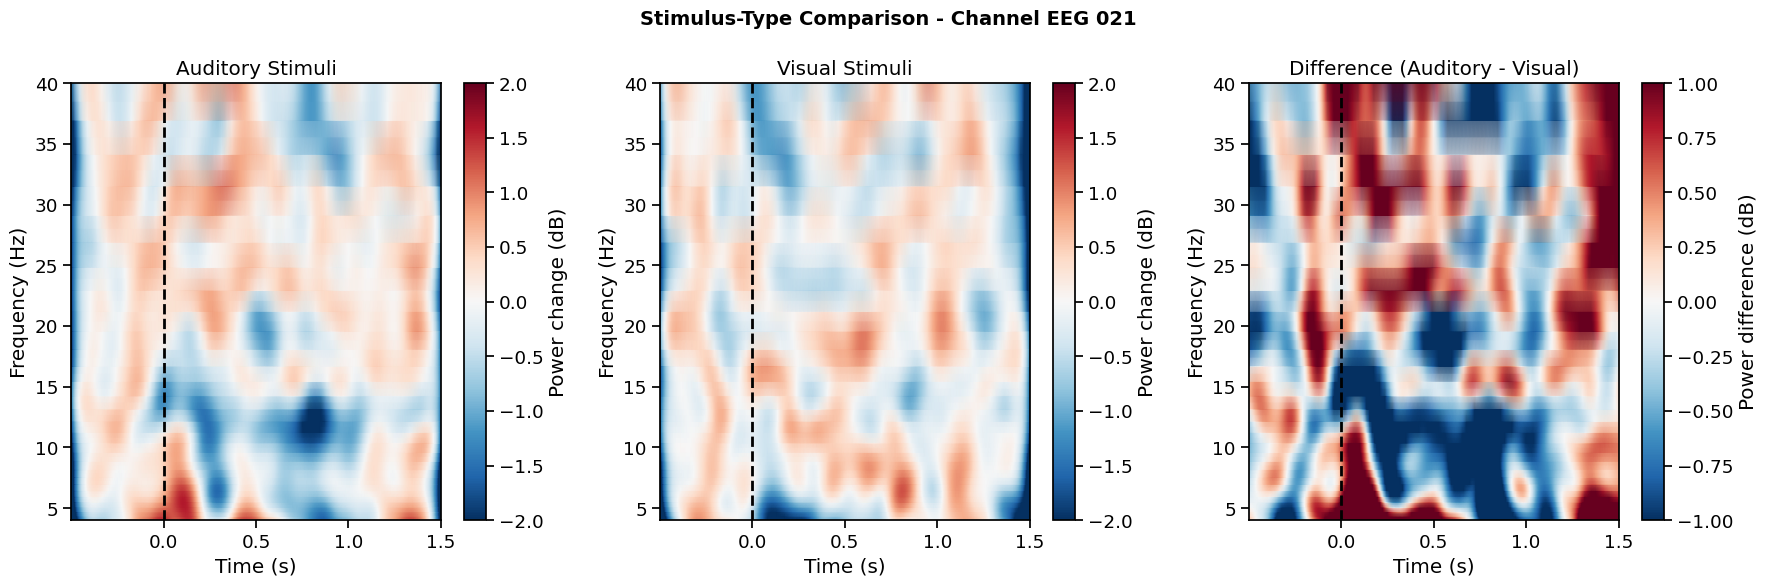

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Auditory
im1 = axes[0].pcolormesh(power_all.times, freqs, ersp_aud, shading='gouraud', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].axvline(0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_title('Auditory Stimuli')
plt.colorbar(im1, ax=axes[0], label='Power change (dB)')

# Visual
im2 = axes[1].pcolormesh(power_visual.times, freqs, ersp_vis, shading='gouraud', cmap='RdBu_r', vmin=-2, vmax=2)
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_title('Visual Stimuli')
plt.colorbar(im2, ax=axes[1], label='Power change (dB)')

# Difference (Auditory - Visual)
diff = ersp_aud - ersp_vis
im3 = axes[2].pcolormesh(power_all.times, freqs, diff, shading='gouraud', cmap='RdBu_r', vmin=-1, vmax=1)
axes[2].axvline(0, color='black', linestyle='--', linewidth=2)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')
axes[2].set_title('Difference (Auditory - Visual)')
plt.colorbar(im3, ax=axes[2], label='Power difference (dB)')

plt.suptitle(f'Stimulus-Type Comparison - Channel {channel}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary and Key Takeaways

### What We Learned

1. **Why Time-Frequency?**
   - Brain signals are non-stationary
   - Different frequencies have different functional roles
   - Need to track when and where oscillations occur

2. **Three Main Methods:**
   - **STFT**: Fast but fixed resolution
   - **Morlet Wavelets**: Adaptive resolution, good for wide frequency ranges
   - **Multitaper**: Best for group statistics, reduced variance

3. **Key Metrics:**
   - **Power**: Total oscillatory activity
   - **ERSP**: Event-related power changes (baseline-corrected)
   - **ITC**: Phase consistency across trials

4. **Frequency Bands:**
   - Each band (theta, alpha, beta, gamma) has distinct functions
   - ERD (desynchronization) often indicates active processing
   - ERS (synchronization) can indicate inhibition or specific computations